# CNN을 활용한 MNIST model
 softmax보다 정확성이 높은 CNN 모델이다. 물론 CNN에서도 softmax 함수를 이용하며 개념 또한 알고있어야한다.<br>
 2개의 CNN과 하나의 fully connected layer을 가지고있는 CNN을 만들어 볼 것이다. 모델을 시각적으로 나타낸다면 아래와 같다.
 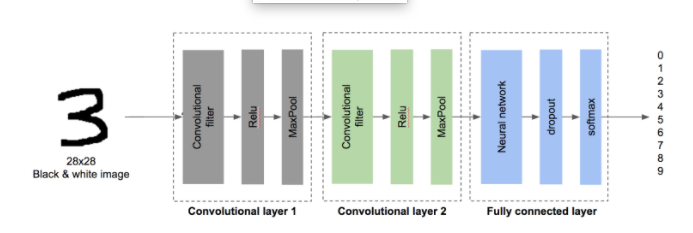

### Conv layer
 conv filter를 통해 특징을 추출하고, activation function으로 ReLu를 사용한다. 후에 MaxPooling으로 주요 특징을 정리하는 레이어이다.<br>
### Fully connected layer
 추출된 특징을 받아 fully connected layer에 의해 분류된다. 하나의 neural network를 사용하며 그 뒤에 dropout 계층을 넣어 overfitting을 방지하며 softmax로 0~9까지의 숫자로 분류하는 작업을 진행한다.

- - -
# data 로딩
 softmax에서 진행했던 로딩과 동일하다.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

# jupyter notebook에서는 커널을 다시 실행시키지 않는 이상 변수들의 컨택스트가 유지된다.
# 그래서 그래프를 만들어놓고 다시 실행시키면 지워지지 않은 상태에서 다시 그려지므로 에러 발생한다.
# 따라서 초기화를 해주는 작업이다.
tf.reset_default_graph() 

np.random.seed(20160704)
tf.set_random_seed(20160704)

# load data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


- - -
# convolutional layer 1
 입력받은 image 데이터인 28\*28 \* 1 행렬을 5 \* 5 \* 1 사이즈의 필터를 적용하고자 한다. 총 32개의 필터를 적용하여 28 \* 28 \* 32 (32개의 특징)을 추출할 것이다.

### 필터 정의

In [9]:
# define first layer
num_filters1 = 32

x = tf.placeholder(tf.float32, [None, 784])

# None * 784 행렬을 None * 28 * 28 * 1 행렬로 바꿈
x_image = tf.reshape(x, [-1,28,28,1])

# 난수를 생성하여 conv1를 일단 만들어준 것이다. conv1 필터는 자동으로 추후에 만들어질것이다.
W_conv1 = tf.Variable(tf.truncated_normal([5,5,1,num_filters1],
                                          stddev=0.1))

x 는 우리가 입력하는 image 데이터, 784차원으로 되어있다.(28 \* 28) 그런데 우리는 conv 행렬에 대한 연산이 필요하기 때문에 28 \* 28 \* 1 차원의 matrix로 만들어주기 위해 reshape를 사용하였다. reshape(x, [-1,28,28,1]) 에서의 -1은 data가 몇개가 들어올지 모르기 때문에 자동으로 맞춰주는 값이다.<br>
필터를 정의하는 과정에서 5 \* 5 \* 1 행렬을 사용할 예정이고, 32개의 필터가 존재하기 때문에 필터 W_conv1의 차원은 5 \* 5 \* 1 \* 32 가 될 것이다.<br>
즉 나중에 i \* 28 \* 28 * 1 행렬(i번째 28,28,1 행렬) 을 5 \* 5 \* 1 \* i(i번째 행렬) 과 conv하지 않을까 예상하고 다시 다음 코드를 읽어보겠다.

 * tf.reshape에 대한 설명은 https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/api_docs/python/array_ops.html 를 참조하자.

 ### 필터 적용

In [10]:
h_conv1 = tf.nn.conv2d(x_image, W_conv1,
                       strides=[1,1,1,1], padding='SAME')

x_image와 W_conv1을 convolution해주는 과정이다. <br>
stride는 conv 필터가 움직이는 간격을 말한다. 일반적으로 [0], [3] 에는 반드시 1을 사용하고, [1]은 가로 stride 값, [2]는 세로 stride 값인데, [1]과 [2]는 보통 같은 값을 이용한다고 한다. 여기서는 1을 사용하고 있으므로 strides=[1,1,1,1] 으로 설정한 것이다.<br>
필터를 이런식으로 적용하다보면 image가 작아지는 현상이 발생한다. 그래서 특징들이 의도하지 않게 유실되는 것을 막기 위하여 padding을 사용한다. 무의미한 값으로 채움으로써 오버피팅 또한 방지한다.<br>
padding = 'SAME' 을 주게 되면 자동으로 패딩을 삽입하여 입력 mat dim, 출력 mat dim이 같아진다.<br>
padding = 'VALID' 를 주게되면 패딩을 적용하지 않고 출력 mat dim이 작아진다.

### 활성함수(Activation function) 적용
 필터적용 후에 활성함수를 적용하는데, 일반적으로 다들 사용하는 ReLu 함수를 적용시킨다.

In [14]:
# bias 초기화
b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))

# relu를 통해 활성함수 적용
h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)

y = x\*W + b 를 떠올리며 위의 코드에 맞춰보자. 거의 같은 방법으로 진행된다는 것을 알 수 있다. h_conv1 가 결과적으로는 y, 즉 softmax에서의 k이고 h_conv1_cutoff는 y이다.

### Max Pooling
max pooling은 sub sampling, 즉 특징의 수를 줄이는 기법 중 하나이다. 추출된 특징 모두를 가지고 판단할 필요 없이, 일부 특징만 가지고 특징을 판단하는 기법이다.<br>
고 해상도의 큰 사진을 가지고 물론 물체의 식별이 가능하지만, 작은 사진으로도 특징이 있다면 물체를 식별할 수 있다는 것이다.<br>
max pooling은 아래와 같은 방법으로 특징을 뽑아내고 데이터의 크기를 줄일 수 있다. 이렇게 특징의 수를 의도적으로 줄이는 이유는 데이터의 크기가 줄기 때문에 컴퓨팅 파워를 줄이면서 계산이 가능하고, 데이터가 줄어드는 과정에서 overfitting을 방지할 수 있다.
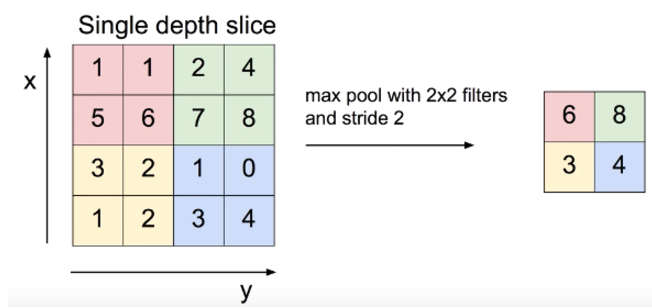

In [16]:
h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

ksize 는 풀링 필터의 사이즈이다. 2 x 2 사이즈로 묶어 풀링을 한다는 의미이다. strides는 전과 같다.<br>
즉 h_pool1의 차원은 [n,14,14,32] 가 될 것이다. -> 추후에 확인해보기.

- - -
# convolutional layer 2
 conv layer 1과 다를것이 없다. 다만 필터를 64개를 사용한다는 점과 들어오는 데이터가 32개(num_filter1)이기 때문에 W_conv2 를 초기화해주는 과정에서 [5,5,32,64] 로 초기화해주어야 한다.

In [17]:
# define second layer
num_filters2 = 64

W_conv2 = tf.Variable(
            tf.truncated_normal([5,5,num_filters1,num_filters2],
                                stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,
                       strides=[1,1,1,1], padding='SAME')

b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)

h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')


W_conv2 = tf.Variable(
            tf.truncated_normal([5,5,num_filters1,num_filters2],
                                stddev=0.1))

[n, 14,14,32] 입력값이 [n, 7, 7, 64]로 리턴되는 것으로 예상된다.

- - -
# fully connected layer
 이러한 특징들을 추출한 결과, 이 특징들을 가지고 입력된 이미지가 0~9중 어느 숫자인지를 파악하는 과정이다.

In [32]:
# define fully connected layer
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

# 7*7*64 는 이미지 하나의 특징 matrix 행렬이라 볼 수 있다.
# 우리는 학습을 위해 1차원으로 다시 변환시켰기 때문에 num_unit1 은 입력값의 수이다.
num_units1 = 7*7*num_filters2

# 학습시키는 뉴런의 수이다.
num_units2 = 10

결과값은 현재 [7, 7] 행렬의 묶음들이라 볼 수 있다. 이를 학습하기 위하여 다시 1차원 행렬로 변환시켜주어야 한다. 그래서 다시 tf.reshape를 사용하여 1차원 행렬로 변환시킨다.
 - 뉴런의 수는 어떻게 정하는 걸까..?

In [33]:
# w2, b2를 초기화해주는 과정이다. 초기화는 랜덤값을 넣던, constant를 넣던, zero를 넣던
# 문제가 되지 않는 것 같다. tensorflow document에서는 모두 랜덤값으로 초기화시켜준다.
w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

In [34]:
keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

위의 코드는 드롭아웃을 구현하고 있다. 드롭아웃은 오버피팅을 막기 위한 계층이며, 아래의 사진을 참고해보자.
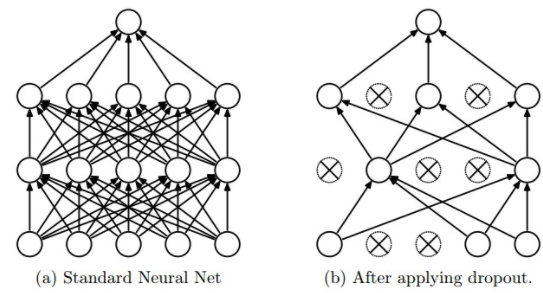
텐서플로우에서는 연결 비율을 위한 placeholder를 하나 설정해준 다음 tf.nn.dropout 함수를 사용해 원래 matrix를 parameter로 값을 전달하면 된다.<br>
연결 비율이란 네트워크 전체가 다 연결되어 있으면 1.0, 50%를 드롭아웃시키면 0.5와 같은 식으로 입력한다. 드롭아웃이 끝나면 남은 matrix인 hidden2_drop을 가지고 소프트맥스 함수를 이용하여 10개의 카테고리로 분류하면 된다.

In [35]:
w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
k = tf.matmul(hidden2_drop, w0) + b0
p = tf.nn.softmax(k)

- - -
# Cost 함수 정의 및 옵티마이저 정의
 이제 학습 모델은 모두 정해졌고, 학습시키기 위한 cost 함수를 정의하자. cost 함수는 softmax를 이용한 MNIST에서 사용했던 크로스 엔트로피 함수를 똑같이 사용할 것이다. 이 비용함수를 최적화하기 위해서 optimizer로는 AdamOptimizer를 사용하였다. 앞의 예제에서는 GradientOptimizer를 사용하였었는데, 일반적으로는 AdamOptimizer를 무난하게 사용한다고 한다.

In [36]:
#define loss (cost) function
t = tf.placeholder(tf.float32, [None, 10])
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = k,labels = t)) 
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [37]:
#define validation function
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [38]:
# prepare session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# start training
i = 0
for _ in range(10000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_vals, acc_vals = [], []
        for c in range(4):
            start = int(len(mnist.test.labels) / 4 * c)
            end = int(len(mnist.test.labels) / 4 * (c+1))
            loss_val, acc_val = sess.run([loss, accuracy],
                feed_dict={x:mnist.test.images[start:end],
                           t:mnist.test.labels[start:end],
                           keep_prob:1.0})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.sum(loss_vals)
        acc_val = np.mean(acc_vals)
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

/home/airi/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Step: 500, Loss: 3.608219, Accuracy: 0.795100
Step: 1000, Loss: 2.658299, Accuracy: 0.861200
Step: 1500, Loss: 2.198871, Accuracy: 0.890200
Step: 2000, Loss: 1.869437, Accuracy: 0.909800
Step: 2500, Loss: 1.629906, Accuracy: 0.920700
Step: 3000, Loss: 1.553831, Accuracy: 0.924100
Step: 3500, Loss: 1.414449, Accuracy: 0.927800
Step: 4000, Loss: 1.265442, Accuracy: 0.935400
Step: 4500, Loss: 1.235497, Accuracy: 0.936500
Step: 5000, Loss: 1.128166, Accuracy: 0.942100
Step: 5500, Loss: 1.060235, Accuracy: 0.946200
Step: 6000, Loss: 0.942543, Accuracy: 0.948800
Step: 6500, Loss: 0.957758, Accuracy: 0.947800
Step: 7000, Loss: 0.934199, Accuracy: 0.948200
Step: 7500, Loss: 0.892622, Accuracy: 0.951100
Step: 8000, Loss: 0.851600, Accuracy: 0.954000
Step: 8500, Loss: 0.828493, Accuracy: 0.954900
Step: 9000, Loss: 0.804383, Accuracy: 0.956200
Step: 9500, Loss: 0.763121, Accuracy: 0.957700
Step: 10000, Loss: 0.767897, Accuracy: 0.956000


In [ ]:

sess = tf.Session()

init = tf.global_variables_initializer() #.run()
sess.run(init)

tmp =  [1., 2., 3., 4., 5., 6., 7., 8., 9.]
y = tf.placeholder(tf.float64, [9])
z = tf.reshape(y, [-1,3, 3,1])

print(sess.run(z, feed_dict={y: tmp}))